#**Task 01**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Create a directory to save plots for your report
OUTPUT_DIR = "eda_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Plots will be saved to: {OUTPUT_DIR}")

Plots will be saved to: eda_plots


In [ ]:
!pip install ydata-profiling

### 1. Load Dataset (Local File)
Make sure the filename below matches the file you uploaded.

In [ ]:
# Define the filename (Change this if your file has a different name)
filename = '/content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
# Fallback name often used
filename_alt = 'Telco-Customer-Churn.csv'

if os.path.exists(filename):
    file_path = filename
elif os.path.exists(filename_alt):
    file_path = filename_alt
else:
    file_path = None
    print("ERROR: CSV file not found! Please upload your dataset to the Colab Files tab on the left.")

if file_path:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from {file_path}")
    print(f"Shape: {df.shape}")
    display(df.head())

Dataset loaded successfully from /content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 21.09it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 2. Data Cleaning & Preprocessing
We need to fix `TotalCharges` (convert to numeric) and handle `SeniorCitizen` encoding.

In [ ]:
if file_path:
    # 1. 'TotalCharges' is often read as object because of empty strings " " for new customers.
    # We force it to numeric, converting errors to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # 2. Fill missing TotalCharges with 0 (these are usually new customers with 0 tenure)
    null_count = df['TotalCharges'].isnull().sum()
    print(f"Found {null_count} missing values in TotalCharges. Filling with 0.")
    df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # 3. SeniorCitizen is 0/1, map to Yes/No for better graphs
    df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

    # 4. Drop customerID as it is not useful for analysis
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    print("Data Cleaning Complete.")

Found 11 missing values in TotalCharges. Filling with 0.
Data Cleaning Complete.


### 3. Target Distribution (Churn)

/tmp/ipython-input-1403040351.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


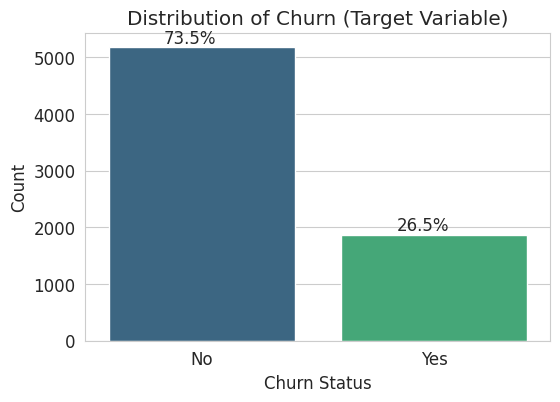

In [ ]:
if file_path:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Churn', data=df, palette='viridis')
    plt.title('Distribution of Churn (Target Variable)')
    plt.xlabel('Churn Status')
    plt.ylabel('Count')

    # Add percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = '{:.1f}%'.format(100 * height/total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = height
            ax.annotate(percentage, (x, y), ha='center', va='bottom')

    plt.savefig(f"{OUTPUT_DIR}/1_churn_distribution.png")
    plt.show()

### 4. Numerical Features Analysis
Checking Tenure, Monthly Charges, and Total Charges.

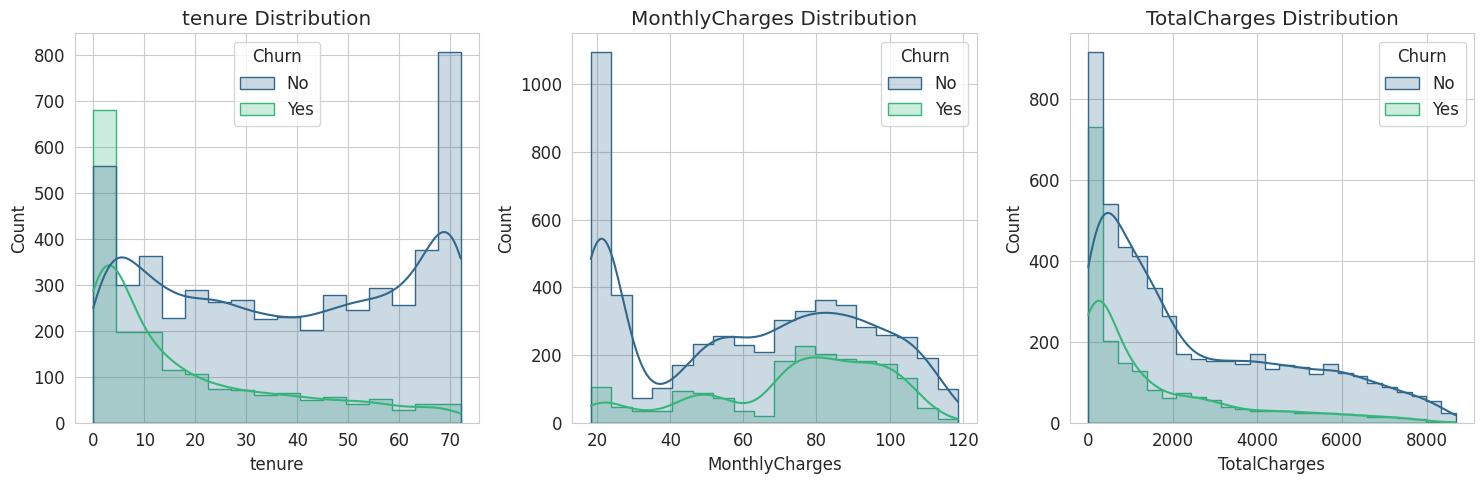

In [ ]:
if file_path:
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(num_cols):
        plt.subplot(1, 3, i+1)
        sns.histplot(data=df, x=col, hue='Churn', kde=True, element="step", palette='viridis')
        plt.title(f'{col} Distribution')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/2_numerical_distributions.png")
    plt.show()

### 4.5. Outlier Detection (Boxplots)
Identifying extreme values in numerical data is crucial for understanding data quality.

/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')
/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')
/tmp/ipython-input-1369182147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], palette='viridis')


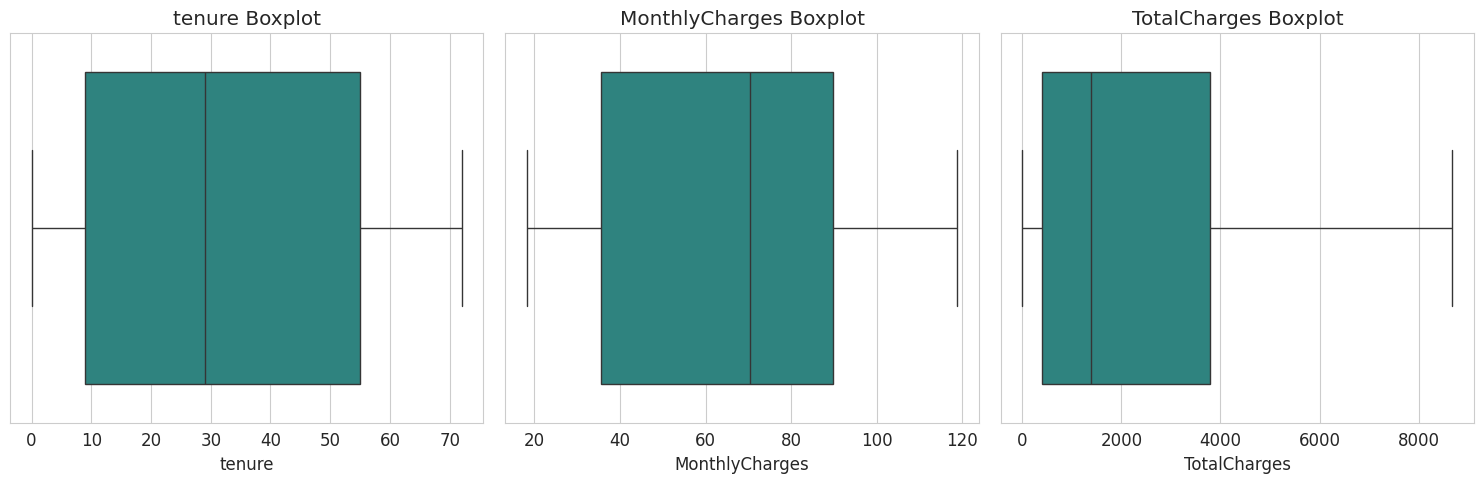

In [ ]:
if file_path:
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(num_cols):
        plt.subplot(1, 3, i+1)
        sns.boxplot(x=df[col], palette='viridis')
        plt.title(f'{col} Boxplot')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/2b_outlier_detection.png")
    plt.show()

### 5. Categorical Features Analysis
Checking Contracts, Payment Methods, Internet Service, etc.

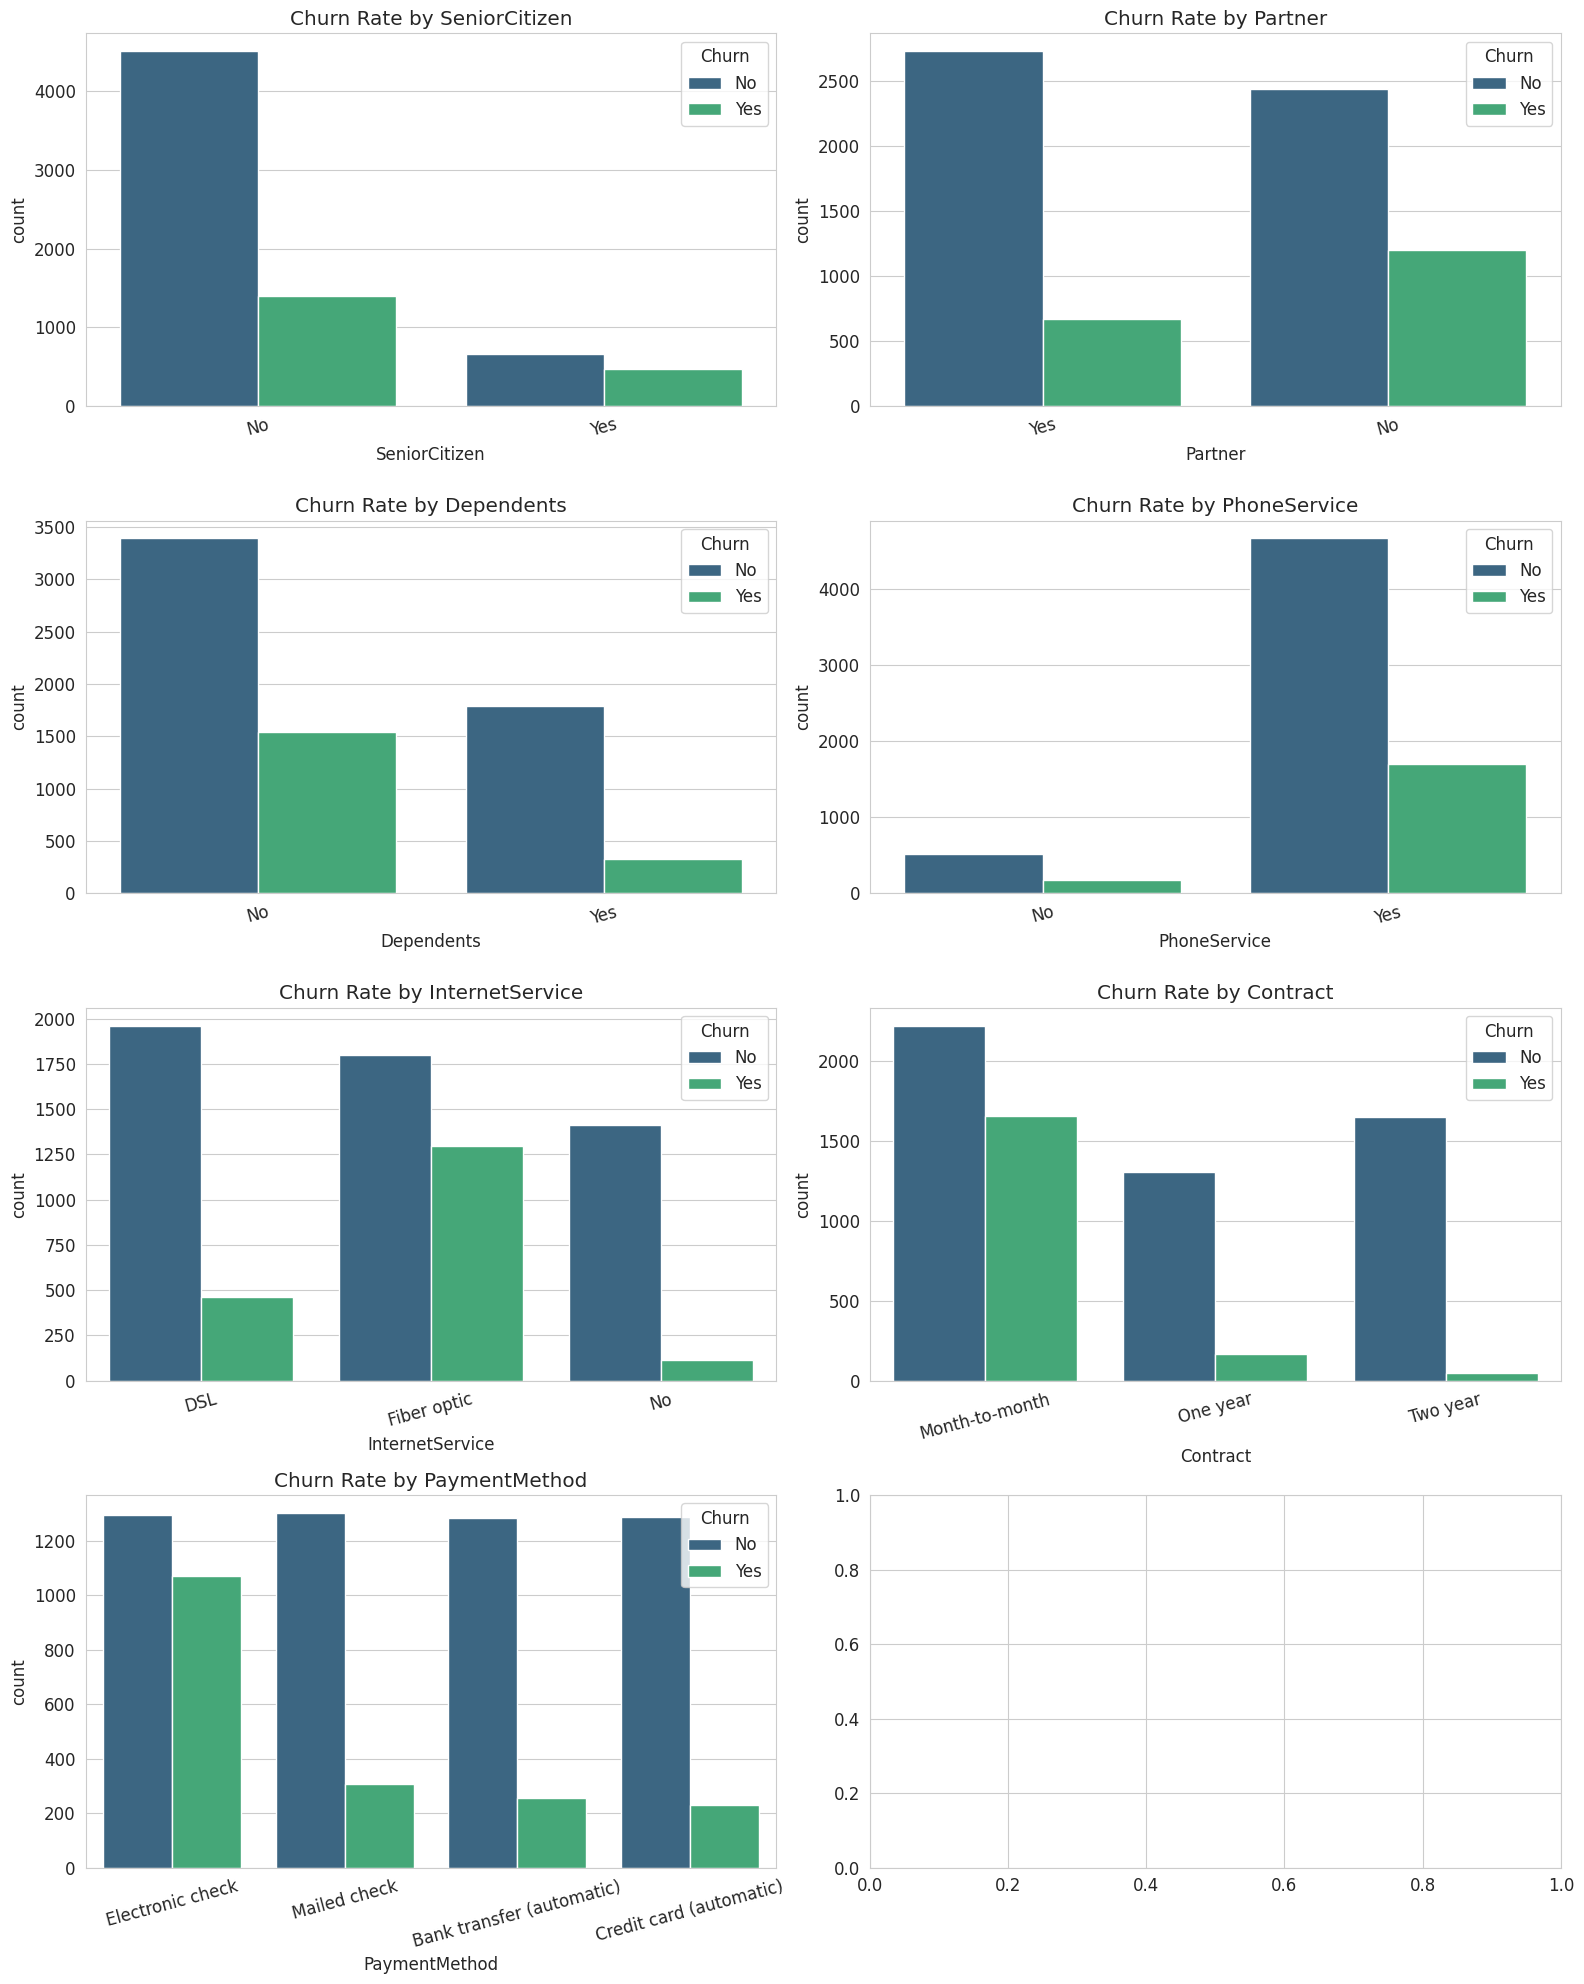

In [ ]:
if file_path:
    cat_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

    # Filter cols that actually exist
    cat_cols = [c for c in cat_cols if c in df.columns]

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        if i < len(axes):
            sns.countplot(data=df, x=col, hue='Churn', ax=axes[i], palette='viridis')
            axes[i].set_title(f'Churn Rate by {col}')
            axes[i].tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/3_categorical_features.png")
    plt.show()

### 6. Correlation Matrix

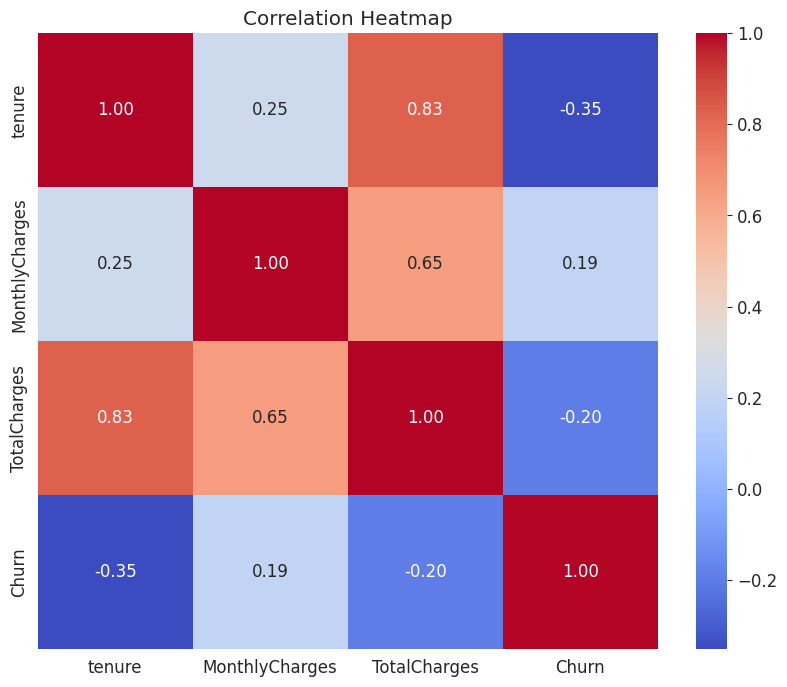

In [ ]:
if file_path:
    # Convert Churn to numeric for correlation
    df_corr = df.copy()
    df_corr['Churn'] = df_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Select only numeric columns
    numeric_df = df_corr.select_dtypes(include=[np.number])

    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.savefig(f"{OUTPUT_DIR}/4_correlation_heatmap.png")
    plt.show()

#**Task 02**

###1. Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-Learn Modules
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score)

# --- 1. SETUP & CONFIGURATION ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Create output folder
OUTPUT_DIRE = "task02_results"
os.makedirs(OUTPUT_DIRE, exist_ok=True)
print(f"Output Directory Created: {OUTPUT_DIRE}/")

Output Directory Created: task02_results/


###2. Data loading & Cleaning

In [ ]:
print("\n[Step 2] Loading Dataset...")

filename = '/content/drive/MyDrive/cw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
if os.path.exists(filename):
    df = pd.read_csv(filename)
    print(" -> Loaded local file.")
else:
    print("ERROR: CSV file not found! Please upload your dataset to the Colab Files tab on the left.")

# Data Cleaning
# Fix TotalCharges: It has spaces " " for new customers. Coerce creates NaNs, we fill with 0.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Drop customerID (irrelevant unique identifier)
if 'customerID' in df.columns:
    df = df.drop(['customerID'], axis=1)

# Encode Target: Yes -> 1, No -> 0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print(f" -> Data Shape after cleaning: {df.shape}")


[Step 2] Loading Dataset...
 -> Loaded local file.
 -> Data Shape after cleaning: (7043, 20)


###3. Preprocessing

In [ ]:
print("\n[Step 3] Preprocessing & Feature Engineering...")

# One-Hot Encoding
# We use drop_first=True to avoid multicollinearity (dummy variable trap)
df_encoded = pd.get_dummies(df, drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Stratified Split
# 'stratify=y' ensures the % of churners is the same in Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Scaling
# Neural Networks perform significantly better with scaled data (Mean=0, Std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" -> Data successfully split and scaled.")


[Step 3] Preprocessing & Feature Engineering...
 -> Data successfully split and scaled.


###4. Decision Tree

In [ ]:
print("\n[Step 4] Training Decision Tree...")

# Parameter Grid
# Included 'class_weight' to handle imbalance automatically
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'class_weight': [None, 'balanced']
}

# Grid Search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    dt_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_grid.fit(X_train_scaled, y_train)
best_dt = dt_grid.best_estimator_

print(f"\n -> Best Tree Params: {dt_grid.best_params_}")


[Step 4] Training Decision Tree...

 -> Best Tree Params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


###5. Neural Network

In [ ]:
print("\n[Step 5] Training Neural Network...")
print(" -> Tuning Hyperparameters (this takes a moment)...")

# Parameter Grid
nn_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.01], # L2 regularization
    'learning_rate_init': [0.001, 0.01]
}

# MLP Classifier
mlp = MLPClassifier(max_iter=500, random_state=RANDOM_SEED)

# Grid Search
nn_grid = GridSearchCV(
    mlp,
    nn_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

nn_grid.fit(X_train_scaled, y_train)
best_nn = nn_grid.best_estimator_

print(f" -> Best Neural Net Params: {nn_grid.best_params_}")


[Step 5] Training Neural Network...
 -> Tuning Hyperparameters (this takes a moment)...
 -> Best Neural Net Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}


###6. Generating Plots

In [ ]:
print("\n[Step 6] Evaluation & Generating Plots...")

# Function to plot Confusion Matrix
def plot_cm(model, X_test, y_test, title, filename):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRE, filename), dpi=300)
    plt.show()


[Step 6] Evaluation & Generating Plots...


###7. Evaluation


--- Decision Tree Results ---
Decision Tree Accuracy: 0.7246
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.72      0.74      1409



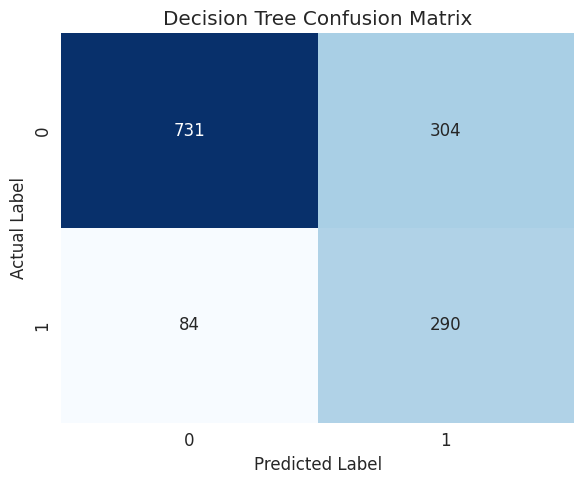


--- Neural Network Results ---
Neural Network Accuracy: 0.7814
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.59      0.56      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



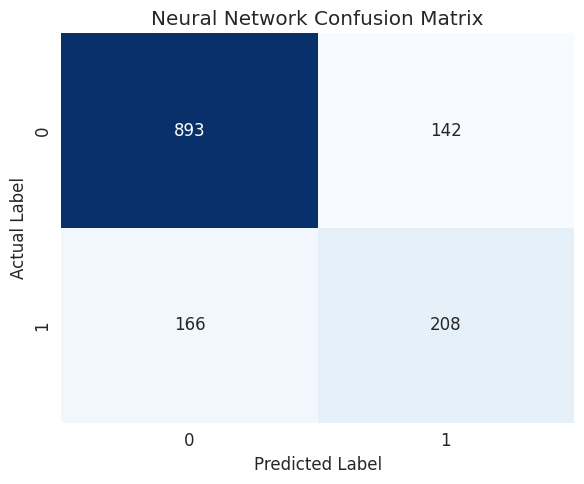

In [ ]:
# 1. Decision Tree Evaluation
print("\n--- Decision Tree Results ---")
y_pred_dt = best_dt.predict(X_test_scaled)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print(classification_report(y_test, y_pred_dt))

# Plot Confusion Matrix for DT
plot_cm(best_dt, X_test_scaled, y_test, "Decision Tree Confusion Matrix", "cm_dt.png")


# 2. Neural Network Evaluation
print("\n--- Neural Network Results ---")
y_pred_nn = best_nn.predict(X_test_scaled)
nn_acc = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(classification_report(y_test, y_pred_nn))

# Plot Confusion Matrix for NN
plot_cm(best_nn, X_test_scaled, y_test, "Neural Network Confusion Matrix", "cm_nn.png")

## Experiment - Applying SMOTE (Oversampling)

In [ ]:
get_ipython().system('pip install imblearn')
print("imblearn installed.")

imblearn installed.


In [ ]:
from imblearn.over_sampling import SMOTE

print("\nApplying SMOTE for class balancing...")

smote = SMOTE(random_state=RANDOM_SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f" -> Original training set shape: {X_train_scaled.shape}, {y_train.shape}")
print(f" -> SMOTE balanced training set shape: {X_train_smote.shape}, {y_train_smote.shape}")
print(f" -> Class distribution after SMOTE: {y_train_smote.value_counts()}")


Applying SMOTE for class balancing...
 -> Original training set shape: (5634, 30), (5634,)
 -> SMOTE balanced training set shape: (8278, 30), (8278,)
 -> Class distribution after SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [ ]:
print("\nRetraining Decision Tree with SMOTE balanced data...")

# Re-initialize GridSearchCV for Decision Tree with SMOTE data
dt_grid_smote = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_SEED),
    dt_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_grid_smote.fit(X_train_smote, y_train_smote)
best_dt_smote = dt_grid_smote.best_estimator_

print(f" -> Best Tree Params (SMOTE): {dt_grid_smote.best_params_}")


Retraining Decision Tree with SMOTE balanced data...
 -> Best Tree Params (SMOTE): {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}


In [ ]:
print(
    "\nRetraining Neural Network with SMOTE balanced data..."
)
print(" -> Tuning Hyperparameters (this takes a moment)...")

# Re-initialize GridSearchCV for Neural Network with SMOTE data
# Use the same parameters as before
nn_grid_smote = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=RANDOM_SEED),
    nn_params,
    cv=3,
    scoring='f1',
    n_jobs=-1,
)

nn_grid_smote.fit(X_train_smote, y_train_smote)
best_nn_smote = nn_grid_smote.best_estimator_

print(f" -> Best Neural Net Params (SMOTE): {nn_grid_smote.best_params_}")


Retraining Neural Network with SMOTE balanced data...
 -> Tuning Hyperparameters (this takes a moment)...
 -> Best Neural Net Params (SMOTE): {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



--- Decision Tree Results (SMOTE) ---
Decision Tree Accuracy (SMOTE): 0.7317
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1035
           1       0.50      0.66      0.57       374

    accuracy                           0.73      1409
   macro avg       0.68      0.71      0.69      1409
weighted avg       0.76      0.73      0.74      1409



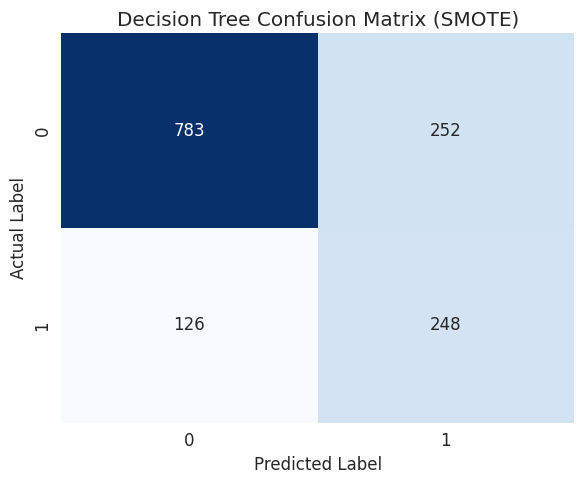


--- Neural Network Results (SMOTE) ---
Neural Network Accuracy (SMOTE): 0.7530
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1035
           1       0.53      0.59      0.56       374

    accuracy                           0.75      1409
   macro avg       0.69      0.70      0.69      1409
weighted avg       0.76      0.75      0.76      1409



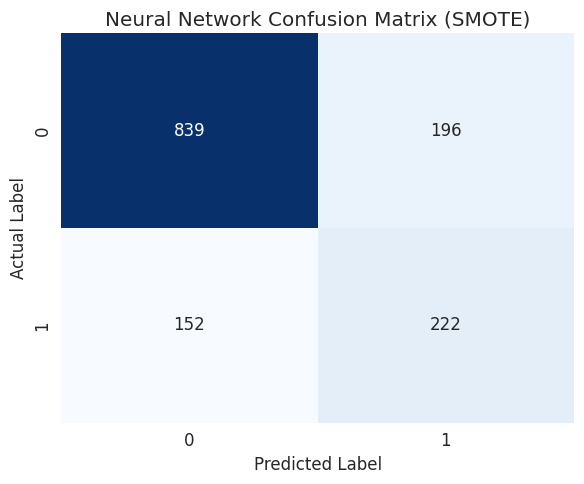

In [ ]:
print("\n--- Decision Tree Results (SMOTE) ---")
y_pred_dt_smote = best_dt_smote.predict(X_test_scaled)
dt_acc_smote = accuracy_score(y_test, y_pred_dt_smote)
print(f"Decision Tree Accuracy (SMOTE): {dt_acc_smote:.4f}")
print(classification_report(y_test, y_pred_dt_smote))

# Plot Confusion Matrix for DT (SMOTE)
plot_cm(best_dt_smote, X_test_scaled, y_test, "Decision Tree Confusion Matrix (SMOTE)", "cm_dt_smote.png")


print("\n--- Neural Network Results (SMOTE) ---")
y_pred_nn_smote = best_nn_smote.predict(X_test_scaled)
nn_acc_smote = accuracy_score(y_test, y_pred_nn_smote)
print(f"Neural Network Accuracy (SMOTE): {nn_acc_smote:.4f}")
print(classification_report(y_test, y_pred_nn_smote))

# Plot Confusion Matrix for NN (SMOTE)
plot_cm(best_nn_smote, X_test_scaled, y_test, "Neural Network Confusion Matrix (SMOTE)", "cm_nn_smote.png")

### Summary:

### Data Analysis Key Findings

*   **SMOTE Application:** The SMOTE oversampling technique successfully balanced the training data, increasing the minority class ('Churn 1') to match the majority class ('Churn 0'). The original training set contained 5634 samples, which expanded to 8278 samples after SMOTE, with an equal distribution of 4139 samples for each class.
*   **Decision Tree Model Retraining & Evaluation:**
    *   The Decision Tree model, retrained with SMOTE-balanced data, achieved an accuracy of 0.7317 on the test set.
    *   For the minority class (Class 1), it showed a Precision of 0.50, Recall of 0.66, and an F1-score of 0.57. The best hyperparameters found were `{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}`.
*   **Neural Network Model Retraining & Evaluation:**
    *   The Neural Network model, retrained with SMOTE-balanced data, achieved an accuracy of 0.7530 on the test set.
    *   For the minority class (Class 1), it exhibited a Precision of 0.53, Recall of 0.59, and an F1-score of 0.56. The best hyperparameters were `{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}`.
    *   A `ConvergenceWarning` was noted during Neural Network training, suggesting the model did not fully converge.

### Insights or Next Steps

*   Both models showed improved handling of the minority class (Class 1) compared to likely imbalanced training, with Recall values of 0.66 for Decision Tree and 0.59 for Neural Network, which are crucial for identifying churn. The Neural Network achieved slightly higher overall accuracy (0.7530 vs. 0.7317) and F1-score for the minority class (0.56 vs. 0.57).
*   Further investigation into the Neural Network's `ConvergenceWarning` is recommended. Techniques like increasing the maximum number of iterations, adjusting the learning rate, or using different optimizers could potentially improve its performance and ensure full convergence.


In [ ]:
print("\nDefining ROC Curve plotting function...")

def plot_roc_curve(model, X_test, y_test, title, filename):
    """
    Generates and plots an ROC curve, calculates AUC, and saves the plot.

    Args:
        model: Trained scikit-learn model with a predict_proba method.
        X_test: Test features.
        y_test: True labels for the test set.
        title (str): Title for the plot.
        filename (str): Filename to save the plot.
    """
    # Predict probabilities for the positive class (Churn=1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Create plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    # Set labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} (AUC = {roc_auc:.2f})')
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Save and show plot
    plt.savefig(os.path.join(OUTPUT_DIRE, filename), dpi=300)
    plt.show()

print(" -> ROC Curve plotting function defined.")


Defining ROC Curve plotting function...
 -> ROC Curve plotting function defined.



Generating ROC Curves for all models...


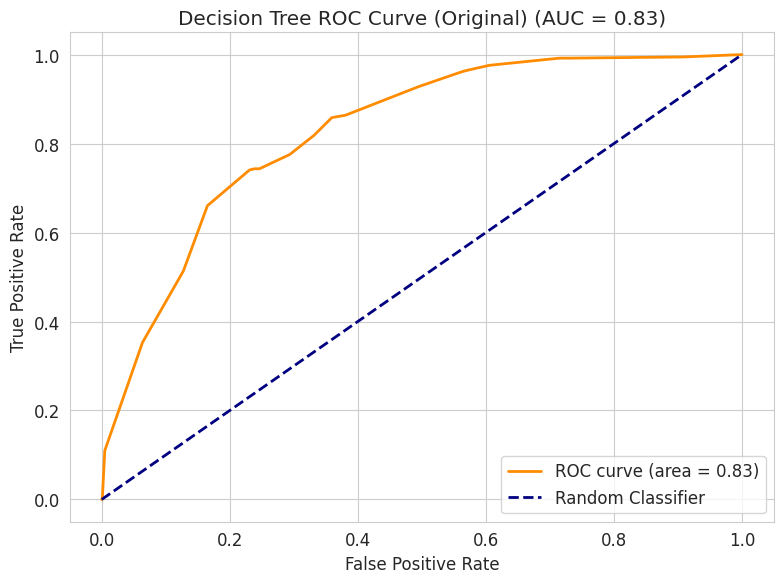

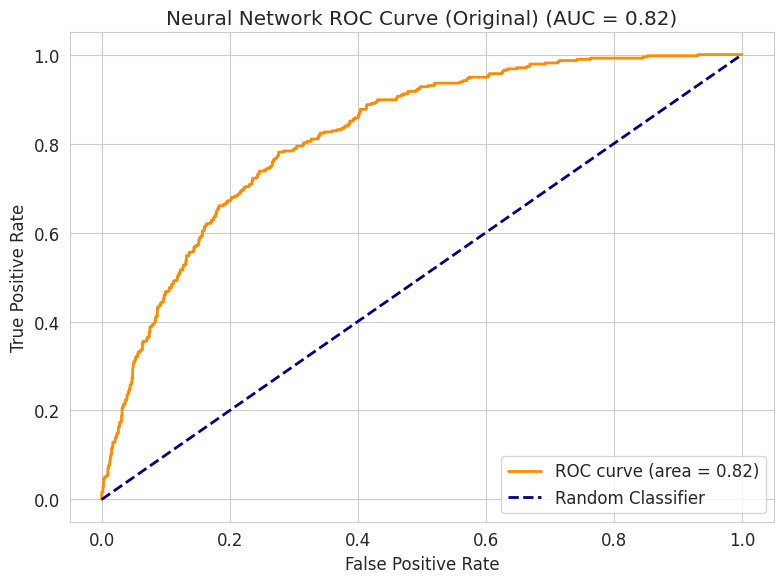

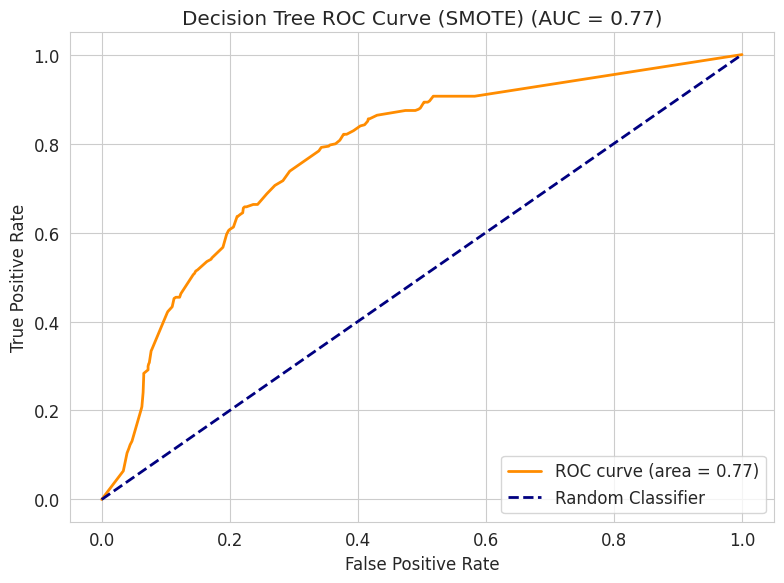

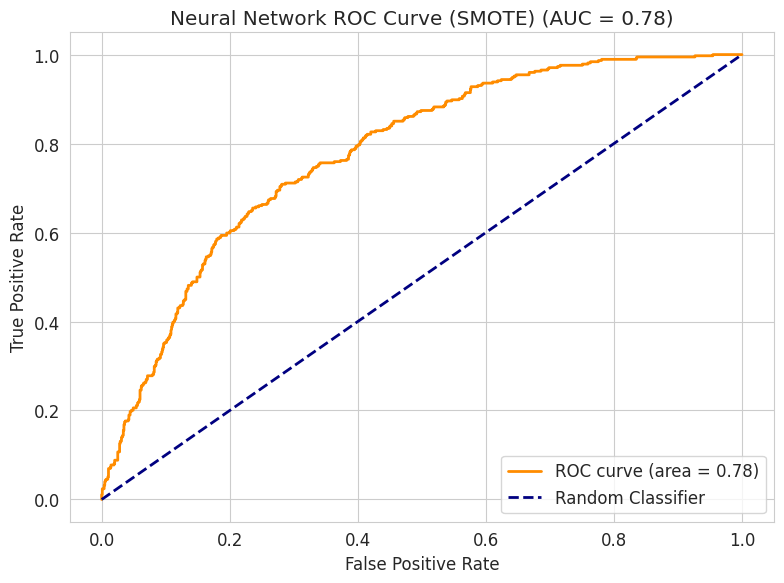

 -> All ROC curves generated and saved.


In [ ]:
print("\nGenerating ROC Curves for all models...")

# 1. ROC for Original Decision Tree
plot_roc_curve(best_dt, X_test_scaled, y_test,
               "Decision Tree ROC Curve (Original)", "roc_dt_original.png")

# 2. ROC for Original Neural Network
plot_roc_curve(best_nn, X_test_scaled, y_test,
               "Neural Network ROC Curve (Original)", "roc_nn_original.png")

# 3. ROC for SMOTE-trained Decision Tree
plot_roc_curve(best_dt_smote, X_test_scaled, y_test,
               "Decision Tree ROC Curve (SMOTE)", "roc_dt_smote.png")

# 4. ROC for SMOTE-trained Neural Network
plot_roc_curve(best_nn_smote, X_test_scaled, y_test,
               "Neural Network ROC Curve (SMOTE)", "roc_nn_smote.png")

print(" -> All ROC curves generated and saved.")